# Fig 2. SI 

Bar plots for different thresholds/metrics


In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, statsmodels

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4
import matplotlib.patches as mpatches
from scipy.stats import norm
import pickle

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *
from functions import *
from utils import *
from plotscript import * # anything useful here? otherwise delete. 

# import dem4cli
sys.path.append(os.path.join(os.environ['VSC_DATA_VO_USER'],'demographics4climate/'))
from population_demographics import * 

In [2]:
start_message()

flags: {'models': 'ISIMIP3a', 'experiment': 'obsclim', 'metric': 'WBGT', 'method': 'shift_fit', 'time_method': None, 'shift_sigma': True, 'shift_period': (1901, 2019), 'shift_loglike': None, 'chunk_version': 0, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'EC-Earth3', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_

In [3]:
from dask.distributed import Client 
client = Client()
client

/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39763 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39763/status,
Dashboard: http://127.0.0.1:39763/status,Workers: 2
Total threads: 2,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38509,Workers: 2
Dashboard: http://127.0.0.1:39763/status,Total threads: 2
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:42471,Total threads: 1
Dashboard: http://127.0.0.1:41259/status,Memory: 20.00 GiB
Nanny: tcp://127.0.0.1:32921,


In [4]:
figdir = os.path.join(figdirs, 'fig_feb25')




# Functions 


In [5]:
# model median and range

def plot_barplot_n_prop_people_atleastx_median(da, 
                                                  unit, 
                                                  ax, 
                                                  proportion=False, 
                                                  x_hot_days = [1,5,10,20,50],
                                                 legend=True,
                                                 errcolor='gray',
                                                 color=None,
                                                 set_xticklabel=True,
                                                 rotation=40,
                                                 ylabel=None,
                                                 alpha_scale=False,
                                                 width=.5,
                                                 leg_title='Attributable days per year'):
    # plot range 
    if unit == 1e9:
        unit_str = 'billions'
    elif unit == 1e6:
        unit_str='millions'
    else:
        unit_str = ''

    upper_error = (da.max(dim='model')-da.astype(float).median(dim='model')).values.T /unit
    lower_error = (da.astype(float).median(dim='model')-da.min(dim='model')).values.T /unit
    try:
        concatenated =np.concatenate((lower_error,upper_error), axis=1)
        reshaped = np.reshape(concatenated, (len(da.features), 2, len(da.age_ranges)))
    except:
        concatenated =np.concatenate((lower_error,upper_error))
        reshaped = np.reshape(concatenated, (2, len(da.age_ranges)))

    # plot multi-model mean 
    if color == None:
        (da.astype(float).median(dim='model')/unit).to_pandas().plot.bar(ax=ax,
                                                   yerr=reshaped,
                                                   error_kw=dict(ecolor=errcolor, alpha=1, elinewidth=.8, capsize=1),
                                                        legend=False)
    else:
        bars = (da.astype(float).median(dim='model')/unit).to_pandas().plot.bar(ax=ax,
                                                   yerr=reshaped,
                                                         color=color,
                                                        width=width,
                                                   error_kw=dict(ecolor=errcolor, alpha=1, elinewidth=.8, capsize=1),
                                                               legend=False)
        # for SI figure - plot all the different thresholds with same color but different alphas
        if alpha_scale:
            alphas = np.linspace(0.2, 1, len(da_n_people_ndays_obs.features))
            for idx, bar_group in enumerate(bars.containers[1::2] ):  # 'containers' holds the bar groups for each dataset
                for bar in bar_group:
                    bar.set_alpha(alphas[idx])



    if ylabel is None:
        if proportion:
            ax.set_ylabel(f'Proportion of age group (%)')

        else:
            ax.set_ylabel(f'Number of people ({unit_str})')
    else:
        ax.set_ylabel(ylabel)

    ax.set_xlabel(' ')
    
    if set_xticklabel:
        step_ages = int(da.age_ranges[1] -da.age_ranges[0] - 1)
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+step_ages}' for x in da.age_ranges.values],  
                      rotation=rotation, rotation_mode='anchor',ha='right') #'horizontal'
    else:
        ax.set_xticklabels('')
    
    if legend==True:
        leg = ax.legend(labels = [f'$\geq${x}' for x in x_hot_days],
                  title=leg_title,
                 frameon=False,
                 fontsize=9,
                 handlelength=1.2,handletextpad=0.4,labelspacing = .1, # reduce spacing 
                bbox_to_anchor=(0, 1.2),
                  loc='upper left'
                 )
        leg._legend_box.align = "left"
        #leg.get_frame().set_linewidth(0.0)


In [6]:
def plot_percapitadays_median_iqr(da, 
                                  feature, 
                                  ax,
                                  set_xticklabel=True,
                                  set_xticks=True,
                                  ylabel='Per capita attributable \nhot-humid days per year',
                                 rotation=40,
                                 legend=False,
                                 leg_title=None,
                                 positions=range(1, 11),
                                 alpha=1,
                                 widths=0.5):
    
    df_plot =  da.sel(features=feature).to_pandas()
    
    medianprops = dict(color='k',linewidth=2)
    whiskerprops = dict(color='none')
    capprops = dict(color='none')

    plot = ax.boxplot(df_plot,  
                      whiskerprops=whiskerprops, 
                      capprops=capprops, 
                      medianprops=medianprops,
                      widths=widths,
                      patch_artist=True,
                      showfliers=False,
                     positions=positions
                     ) #boxprops=boxprops,

    col='cadetblue'
    for patch in plot['boxes']:
        patch.set_facecolor(col)
        patch.set_edgecolor(col)
        patch.set_alpha(alpha)

    if set_xticklabel:
        ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.columns], 
                      rotation=rotation,rotation_mode='anchor',ha='right');
    else:
        ax.set_xticklabels('')
        if not set_xticks:
            ax.set_xticks([])
            
    ax.set_ylabel(ylabel)

    if legend==True:
        leg = ax.legend(
                  title=leg_title,
                 frameon=False,
                 fontsize=9,
                 handlelength=1.2,handletextpad=0.4,labelspacing = .1, # reduce spacing 
                bbox_to_anchor=(0, 1.2),
                  loc='upper left'
                 )
        leg._legend_box.align = "left"


In [7]:
def df_summary_mean_range(da,feature,units):
    
    if units > 100:
        df_summary = da.sel(features=feature).to_pandas().T / units
    elif units == 100:
        df_summary = da.sel(features=feature).to_pandas().T * units
    elif units == None:
         df_summary = da.sel(features=feature).to_pandas().T
    df_summary['mean'] = df_summary.iloc[:,0:6].mean(axis=1)
    df_summary['min'] = df_summary.iloc[:,0:6].min(axis=1)
    df_summary['max'] = df_summary.iloc[:,0:6].max(axis=1)
    df_summary = df_summary.astype(float)
    
    return df_summary.round(decimals=1)


def df_summary_median_iqr(da,feature,units=None):
    df_summary = da.sel(features=feature).to_pandas().T
    df_summary['median'] = df_summary.iloc[:,0:6].median(axis=1)
    df_summary['Q1'] = df_summary.iloc[:,0:6].quantile(0.25,axis=1)
    df_summary['Q3'] = df_summary.iloc[:,0:6].quantile(0.75,axis=1)
    df_summary = df_summary.astype(float)

    return df_summary.round(decimals=1)
    

In [8]:
def calc_nAHD_shift_fit_percentile_from_sample(da_params, 
                                             percentile, 
                                             gmst_smo,
                                               samples_pi,
                                             year_pres=2023,
                                             GWI=1.3,
                                            #mc_samplesize=1000,
                                            ):

    gmst_pres = float(gmst_smo.loc[year_pres]) 

    b0 = da_params.sel(params='b0')
    b1 = da_params.sel(params='b1')
    
    # Get params
    if len(da_params.params) > 3:
        sigma_b0 = da_params.sel(params='sigma_b0')
        sigma_b1 = da_params.sel(params='sigma_b1')
        mean_pi = b0 + b1 * gmst_pi
        mean_pres = b0 + b1 * gmst_pres
        std_pi = sigma_b0 + sigma_b1 * gmst_pi
        std_pres = sigma_b0 + sigma_b1 * gmst_pres
    else:
        sigma_b0 = da_params.sel(params='sigma')
        mean_pi = b0 + b1 * gmst_pi
        mean_pres = b0 + b1 * gmst_pres
        std_pi = sigma_b0
        std_pres = sigma_b0

    # theoretical distributions per month in present for later 
    norm_pres = norm(loc=mean_pres, scale=std_pres)
    

    # weights 
    coords = dict(month=("month", np.arange(1,13)))
    days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) # ignoring leap years
    weights = xr.DataArray(days_in_month, dims="month", coords=coords)
    
    # weigh the sample by month length and get qth percentile value 
    da_threshold = samples_pi.weighted(weights).quantile(percentile, dim=['samples','month'])

    # expand dims
    da_threshold = da_threshold.expand_dims('month', axis=1)
    # get p of exceedance of pi 90th percentile threshold in each grid cell 
    data = norm_pres.sf(da_threshold)
    da_p1 = xr.DataArray(
        data=data,
        dims=["dataset", "month", "lat", "lon", ],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )
    
    # calc nAHD per month and per year
    da_nAHD_mo = (da_p1 -  (1 - percentile)) *  weights 
    
    da_nAHD = da_nAHD_mo.sum(dim='month')

    return da_nAHD, da_nAHD_mo, da_threshold, da_p1
    

In [9]:
def get_gmst_smo(ntime=4):
    
    df_gmst_obs_annual = pd.read_csv(os.path.join(datadirs,'gmst/gmst-obs/forster2024/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
    gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=ntime))
    
    return gmst_smo

# Data prep

## 0. Population preprocessing


In [10]:
gs_population_global = population_demographics_gridscale_global(startyear=2023,
                                                                endyear=2023,
                                                                ssp=2,
                                                                urbanrural=False)

# add message that say n of countries !

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


## 1. WBGT28

### Reanalysis 


In [11]:
flags['models']='ISIMIP3a'
dirname = 'output_shift-fit' 
start_year=1950 
dir_shift_fit = 'forster2024-hitol-nan'

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join(outdirs, 
                                      f'{dirname}/{dir_shift_fit}/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_{start_year}_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params = xr.concat(da_list, dim="dataset")
    

In [12]:
gmst_smo = get_gmst_smo()

In [13]:
threshold = 28
GWI=1.3

from scipy.stats import norm

da_nAHD_obs, da_nAHD_mo, da_p0, da_p1 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=GWI)

In [14]:
da_nAHD = da_nAHD_obs.rename({'dataset':'model'})

da_n_people_ndays_obs, da_prop_people_ndays_obs = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

### Climate models

In [15]:
dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 


In [16]:
da_nAHD = da_nAHD_models

da_n_people_ndays_models, da_prop_people_ndays_models = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

## 3. WBGT30

In [17]:
# Observations 

threshold = 30

da_nAHD_obs_30, da_nAHD_mo_30, da_p0_30, da_p1_30 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=1.3)

da_nAHD = da_nAHD_obs_30.rename({'dataset':'model'})

da_n_people_ndays_obs_30, da_prop_people_ndays_obs_30 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_30 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [18]:
# climate models 

dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models_30 = open_all_nAHD(GCMs,  metric='WBGT30', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_30

da_n_people_ndays_models_30, da_prop_people_ndays_models_30 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_30 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

## 4. WBGT33 (maybe don't include?)

In [19]:
threshold = 33

da_nAHD_obs_33, da_nAHD_mo_33, da_p0_33, da_p1_33 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=1.3)

da_nAHD = da_nAHD_obs_33.rename({'dataset':'model'})

da_n_people_ndays_obs_33, da_prop_people_ndays_obs_33 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_33 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [20]:
# climate models 

dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models_33 = open_all_nAHD(GCMs,  metric='WBGT33', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_33

da_n_people_ndays_models_33, da_prop_people_ndays_models_33 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_33 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

## 5. WBGT90,95,99 

### Models 

In [21]:
# climate models 

dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models_W99 = open_all_nAHD(GCMs,  metric='WBGT99', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_W99

da_n_people_ndays_models_W99, da_prop_people_ndays_models_W99 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_W99 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [22]:

da_nAHD_models_W90 = open_all_nAHD(GCMs,  metric='WBGT90', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_W90

da_n_people_ndays_models_W90, da_prop_people_ndays_models_W90 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_W90 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                           mask_where_decr=False
                                                                           )

In [23]:

da_nAHD_models_W95 = open_all_nAHD(GCMs,  metric='WBGT95', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_W95

da_n_people_ndays_models_W95, da_prop_people_ndays_models_W95 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_W95 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

### Obs

In [24]:
metric='WBGT'
start_year=1950
inDIR=os.path.join(outdirs,f'output_shift-fit/{dir_shift_fit}/WBGT/ISIMIP3a/sample_pi/GWI{str(GWI)}/')

pctl=0.9
files = [ os.path.join(inDIR,f'{VAR}_{metric}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_{start_year}_2019_GWI{str(GWI)}.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_W90, da_nAHD_obs_mo_W90, da_threshold_obs_W90, da_p1_obs_W90 = [ xr.open_dataarray(f) for f in files] 

pctl=0.95
files = [ os.path.join(inDIR,f'{VAR}_{metric}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_{start_year}_2019_GWI{str(GWI)}.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_W95, da_nAHD_obs_mo_W95, da_threshold_obs_W95, da_p1_obs_W95 = [ xr.open_dataarray(f) for f in files] 

pctl=0.99
files = [ os.path.join(inDIR,f'{VAR}_{metric}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_{start_year}_2019_GWI{str(GWI)}.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_W99, da_nAHD_obs_mo_W99, da_threshold_obs_W99, da_p1_obs_W99 = [ xr.open_dataarray(f) for f in files] 


In [25]:

da_nAHD = da_nAHD_obs_W99.rename({'dataset':'model'})

da_n_people_ndays_obs_W99, da_prop_people_ndays_obs_W99 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_W99 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


In [26]:

da_nAHD = da_nAHD_obs_W95.rename({'dataset':'model'})

da_n_people_ndays_obs_W95, da_prop_people_ndays_obs_W95 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_W95 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


In [27]:

da_nAHD = da_nAHD_obs_W90.rename({'dataset':'model'})

da_n_people_ndays_obs_W90, da_prop_people_ndays_obs_W90 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_W90 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


## 6. TX95, TX99 

### Models

In [28]:
da_nAHD_TX90_models = open_all_nAHD(GCMs,  metric='TX90', outdirname=dirname, year_pres=year) 
da_nAHD_TX95_models = open_all_nAHD(GCMs,  metric='TX95', outdirname=dirname, year_pres=year)  
da_nAHD_TX99_models = open_all_nAHD(GCMs,  metric='TX99', outdirname=dirname, year_pres=year) 

In [29]:
da_nAHD = da_nAHD_TX90_models

da_n_people_ndays_models_TX90, da_prop_people_ndays_models_TX90 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_TX90 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [30]:
da_nAHD = da_nAHD_TX95_models

da_n_people_ndays_models_TX95, da_prop_people_ndays_models_TX95 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_TX95 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [31]:
da_nAHD = da_nAHD_TX99_models

da_n_people_ndays_models_TX99, da_prop_people_ndays_models_TX99 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_TX99 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

### Obs

In [32]:
metric='TX'
inDIR=os.path.join(outdirs,f'output_shift-fit/{dir_shift_fit}/{metric}/ISIMIP3a/sample_pi/GWI{str(GWI)}/')

pctl=0.9
files = [ os.path.join(inDIR,f'{VAR}_{metric}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_{start_year}_2019_GWI{str(GWI)}.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_TX90, da_nAHD_obs_mo_TX90, da_threshold_obs_TX90, da_p1_obs_TX90 = [ xr.open_dataarray(f) for f in files] 

pctl=0.95
files = [ os.path.join(inDIR,f'{VAR}_{metric}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_{start_year}_2019_GWI{str(GWI)}.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_TX95, da_nAHD_obs_mo_TX95, da_threshold_obs_TX95, da_p1_obs_TX95 = [ xr.open_dataarray(f) for f in files] 

pctl=0.99
files = [ os.path.join(inDIR,f'{VAR}_{metric}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_{start_year}_2019_GWI{str(GWI)}.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_TX99, da_nAHD_obs_mo_TX99, da_threshold_obs_TX99, da_p1_obs_TX99 = [ xr.open_dataarray(f) for f in files] 


In [33]:

da_nAHD = da_nAHD_obs_TX99.rename({'dataset':'model'})

da_n_people_ndays_obs_TX99, da_prop_people_ndays_obs_TX99 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_TX99 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


In [34]:

da_nAHD = da_nAHD_obs_TX95.rename({'dataset':'model'})

da_n_people_ndays_obs_TX95, da_prop_people_ndays_obs_TX95 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_TX95 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


In [35]:

da_nAHD = da_nAHD_obs_TX90.rename({'dataset':'model'})

da_n_people_ndays_obs_TX90, da_prop_people_ndays_obs_TX90 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_TX90 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


# Supplementary figures: part 1 bar plots

## 1) number of people

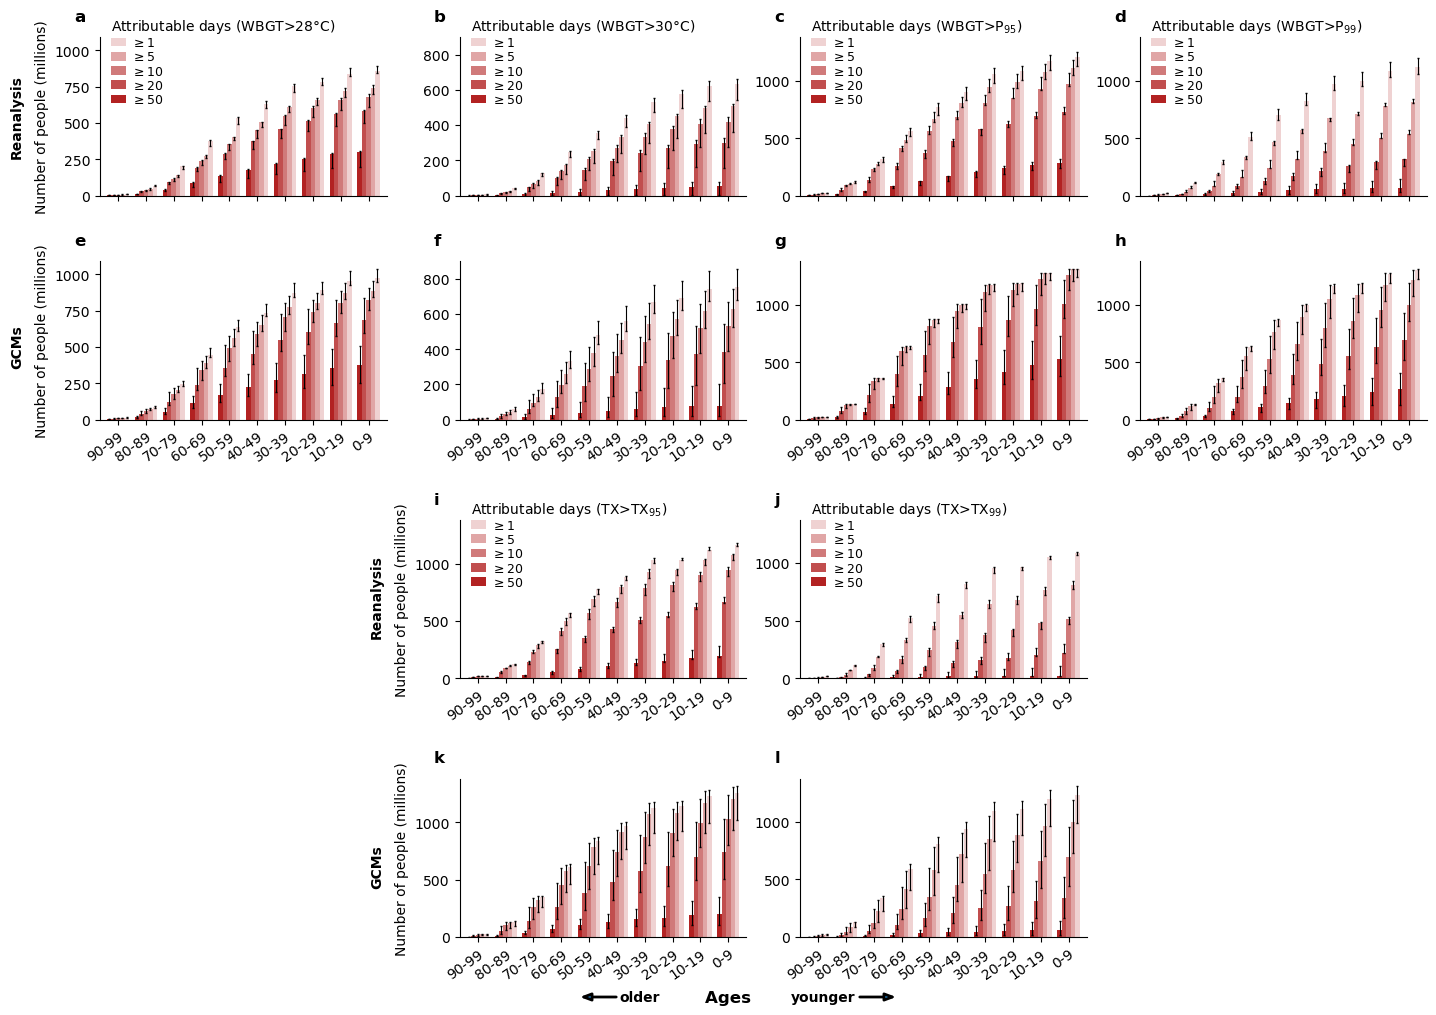

In [47]:
# settings
xpos=-.09
ypos=1.05

fig = plt.figure(figsize=(14, 10), layout='constrained', facecolor='none')  # layout constraint removed
gs = fig.add_gridspec(4, 4)  # Creating a grid with 2 rows and 4 columns

# Subplots
axes = []

# First row (Reanalysis)
axes.append(fig.add_subplot(gs[0, 0]))  # 'a'
axes.append(fig.add_subplot(gs[0, 1]))  # 'b'
axes.append(fig.add_subplot(gs[0, 2]))  # 'c'
axes.append(fig.add_subplot(gs[0, 3]))  # 'd'

# Second row (GCMs)
axes.append(fig.add_subplot(gs[1, 0]))  # 'e'
axes.append(fig.add_subplot(gs[1, 1]))  # 'f'
axes.append(fig.add_subplot(gs[1, 2]))  # 'g'
axes.append(fig.add_subplot(gs[1, 3]))  # 'h'

# Third row (Reanalysis)
axes.append(fig.add_subplot(gs[2, 1]))  # 'i'
axes.append(fig.add_subplot(gs[2, 2]))  # 'j'

# Fourth row (GCMs)
axes.append(fig.add_subplot(gs[3, 1]))  # 'k'
axes.append(fig.add_subplot(gs[3, 2]))  # 'l'


# Plotting
ax = axes[0]
ax.set_title('a', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_n_people_ndays_obs, unit=1e6, ax=ax, proportion=False, 
                                              legend=True, leg_title='Attributable days (WBGT>28$\degree$C)', 
                                              errcolor='k', color='firebrick', set_xticklabel=False, alpha_scale=True, width=.8)

ax = axes[1]
ax.set_title('b', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_n_people_ndays_obs_30, unit=1e6, ax=ax, proportion=False, 
                                              legend=True, leg_title='Attributable days (WBGT>30$\degree$C)', 
                                              errcolor='k', color='firebrick', set_xticklabel=False, alpha_scale=True, width=.8,ylabel='')

ax = axes[2]
ax.set_title('c', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_n_people_ndays_obs_W95, unit=1e6, ax=ax, proportion=False, 
                                              legend=True, leg_title='Attributable days (WBGT>P$_{95}$)', 
                                              errcolor='k', color='firebrick', set_xticklabel=False, alpha_scale=True, width=.8,ylabel='')

ax = axes[3]
ax.set_title('d', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_n_people_ndays_obs_W99, unit=1e6, ax=ax, proportion=False, 
                                              legend=True, leg_title='Attributable days (WBGT>P$_{99}$)', 
                                              errcolor='k', color='firebrick', set_xticklabel=False, alpha_scale=True, width=.8,ylabel='')

ax = axes[4]
ax.set_title('e', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_n_people_ndays_models, unit=1e6, ax=ax, proportion=False, 
                                              legend=False, errcolor='k', color='firebrick', set_xticklabel=True, rotation=35, 
                                              alpha_scale=True, width=.8)

ax = axes[5]
ax.set_title('f', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_n_people_ndays_models_30, unit=1e6, ax=ax, proportion=False, 
                                              legend=False, errcolor='k', color='firebrick', set_xticklabel=True, rotation=35, 
                                              alpha_scale=True, width=.8,ylabel='')

ax = axes[6]
ax.set_title('g', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_n_people_ndays_models_W95, unit=1e6, ax=ax, proportion=False, 
                                              legend=False, errcolor='k', color='firebrick', set_xticklabel=True, rotation=35, 
                                              alpha_scale=True, width=.8,ylabel='')

ax = axes[7]
ax.set_title('h', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_n_people_ndays_models_W99, unit=1e6, ax=ax, proportion=False, 
                                              legend=False, errcolor='k', color='firebrick', set_xticklabel=True, rotation=35, 
                                              alpha_scale=True, width=.8,ylabel='')


ax=axes[8]
ax.set_title('i',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_n_people_ndays_obs_TX95, unit=1e6, ax=ax, proportion=False, 
                                              legend=True, errcolor='k', color='firebrick', set_xticklabel=True, rotation=35, 
                                              alpha_scale=True, width=.8,leg_title='Attributable days (TX>TX$_{95}$)')

ax=axes[9]
ax.set_title('j',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_n_people_ndays_obs_TX99, unit=1e6, ax=ax, proportion=False, 
                                              legend=True, errcolor='k', color='firebrick', set_xticklabel=True, rotation=35, 
                                              alpha_scale=True, width=.8,ylabel='',leg_title='Attributable days (TX>TX$_{99}$)')




ax=axes[10]
ax.set_title('k',loc='left',fontweight='bold',x=xpos,y=ypos)

plot_barplot_n_prop_people_atleastx_median(da_n_people_ndays_models_TX95, unit=1e6, ax=ax, proportion=False, 
                                              legend=False,errcolor='k',
                                              color='firebrick',set_xticklabel=True,rotation=35,
                                              alpha_scale=True,width=.8,
                                             )

ax=axes[11]
ax.set_title('l',loc='left',fontweight='bold',x=xpos,y=ypos)

plot_barplot_n_prop_people_atleastx_median(da_n_people_ndays_models_TX99, unit=1e6,  ax=ax, proportion=False, 
                                              legend=False,errcolor='k',
                                              color='firebrick',set_xticklabel=True,rotation=35,
                                              alpha_scale=True,width=.8,ylabel=''
                                             )




# Scale y axes to match
[axes[i].set_ylim(axes[j].get_ylim()) for i,j in [(0,4),(1,5),(2,6),(3,7),(8,10),(9,11)]]

# Annotations 
fig.text(-.015, .85, 'Reanalysis', ha='left', rotation=90, fontweight='bold')
fig.text(-.015, .64, 'GCMs', ha='left', rotation=90, fontweight='bold')
fig.text(.242, .37, 'Reanalysis', ha='left', rotation=90, fontweight='bold')
fig.text(.242, .12, 'GCMs', ha='left', rotation=90, fontweight='bold')
fig.supxlabel('Ages ', y=0, fontweight='bold')

# Arrow annotation older/younger 
vloc=0.008
arr = mpatches.FancyArrowPatch((0.59, vloc), (0.62, vloc),  # Coordinates in figure fraction
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )
fig.patches.append(arr)
fig.text(0.543, 0.008, "younger", ha='left', va='center', fontweight='bold')
arr = mpatches.FancyArrowPatch((.42, vloc), (.39, vloc),  
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )  
fig.patches.append(arr)
fig.text(0.42, vloc, "older", ha='left', va='center', fontweight='bold')

for ax in axes:
    ax.invert_xaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Save the figure
#plt.savefig(os.path.join(figdir, 'figSI4_npeople.png'), dpi=300, bbox_inches='tight', transparent=True)
#plt.savefig(os.path.join(figdir, 'figSI4_npeople.pdf'), dpi=300, bbox_inches='tight', transparent=True)


## 2) Proportion of people

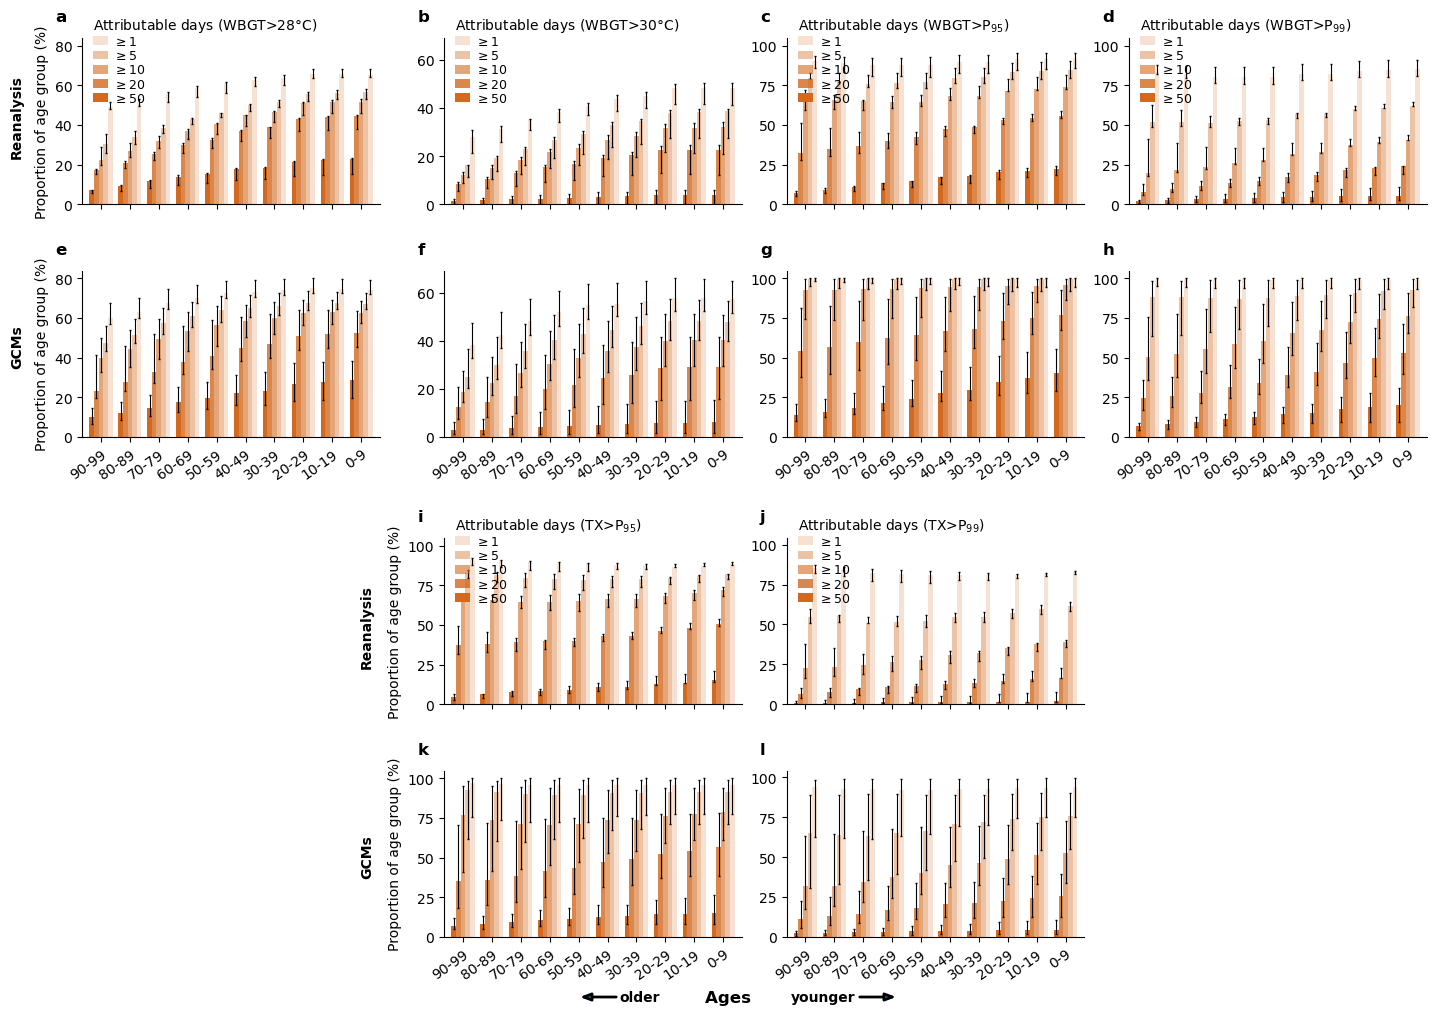

In [48]:
# settings
xpos=-.09
ypos=1.05

fig = plt.figure(figsize=(14, 10), layout='constrained', facecolor='none')  # layout constraint removed
gs = fig.add_gridspec(4, 4)  # Creating a grid with 2 rows and 4 columns

# Subplots
axes = []

# First row (Reanalysis)
axes.append(fig.add_subplot(gs[0, 0]))  # 'a'
axes.append(fig.add_subplot(gs[0, 1]))  # 'b'
axes.append(fig.add_subplot(gs[0, 2]))  # 'c'
axes.append(fig.add_subplot(gs[0, 3]))  # 'd'

# Second row (GCMs)
axes.append(fig.add_subplot(gs[1, 0]))  # 'e'
axes.append(fig.add_subplot(gs[1, 1]))  # 'f'
axes.append(fig.add_subplot(gs[1, 2]))  # 'g'
axes.append(fig.add_subplot(gs[1, 3]))  # 'h'

# Third row (Reanalysis)
axes.append(fig.add_subplot(gs[2, 1]))  # 'i'
axes.append(fig.add_subplot(gs[2, 2]))  # 'j'

# Fourth row (GCMs)
axes.append(fig.add_subplot(gs[3, 1]))  # 'k'
axes.append(fig.add_subplot(gs[3, 2]))  # 'l'


# Plotting
ax = axes[0]
ax.set_title('a', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_prop_people_ndays_obs*100, unit=1, ax=ax, proportion=True, 
                                              legend=True, leg_title='Attributable days (WBGT>28$\degree$C)', 
                                              errcolor='k', color='chocolate', set_xticklabel=False, alpha_scale=True, width=.8)

ax = axes[1]
ax.set_title('b', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_prop_people_ndays_obs_30*100, unit=1, ax=ax, proportion=True, 
                                              legend=True, leg_title='Attributable days (WBGT>30$\degree$C)', 
                                              errcolor='k', color='chocolate', set_xticklabel=False, alpha_scale=True, width=.8,ylabel='')

ax = axes[2]
ax.set_title('c', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_prop_people_ndays_obs_W95*100, unit=1, ax=ax, proportion=True, 
                                              legend=True, leg_title='Attributable days (WBGT>P$_{95}$)', 
                                              errcolor='k', color='chocolate', set_xticklabel=False, alpha_scale=True, width=.8,ylabel='')

ax = axes[3]
ax.set_title('d', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_prop_people_ndays_obs_W99*100, unit=1, ax=ax, proportion=True, 
                                              legend=True, leg_title='Attributable days (WBGT>P$_{99}$)', 
                                              errcolor='k', color='chocolate', set_xticklabel=False, alpha_scale=True, width=.8,ylabel='')

ax = axes[4]
ax.set_title('e', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_prop_people_ndays_models*100, unit=1, ax=ax, proportion=True, 
                                              legend=False, errcolor='k', color='chocolate', set_xticklabel=True, rotation=35, 
                                              alpha_scale=True, width=.8)

ax = axes[5]
ax.set_title('f', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_prop_people_ndays_models_30*100, unit=1, ax=ax, proportion=True, 
                                              legend=False, errcolor='k', color='chocolate', set_xticklabel=True, rotation=35, 
                                              alpha_scale=True, width=.8,ylabel='')

ax = axes[6]
ax.set_title('g', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_prop_people_ndays_models_W95*100, unit=1, ax=ax, proportion=True, 
                                              legend=False, errcolor='k', color='chocolate', set_xticklabel=True, rotation=35, 
                                              alpha_scale=True, width=.8,ylabel='')

ax = axes[7]
ax.set_title('h', loc='left', fontweight='bold', x=xpos, y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_prop_people_ndays_models_W99*100, unit=1, ax=ax, proportion=True, 
                                              legend=False, errcolor='k', color='chocolate', set_xticklabel=True, rotation=35, 
                                              alpha_scale=True, width=.8,ylabel='')


ax=axes[8]
ax.set_title('i',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_prop_people_ndays_obs_TX95*100, unit=1, ax=ax, proportion=True, 
                                              legend=True, leg_title='Attributable days (TX>P$_{95}$)', 
                                              errcolor='k', color='chocolate', set_xticklabel=False, alpha_scale=True, width=.8,)

ax=axes[9]
ax.set_title('j',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_barplot_n_prop_people_atleastx_median(da_prop_people_ndays_obs_TX99*100, unit=1, ax=ax, proportion=True, 
                                              legend=True, leg_title='Attributable days (TX>P$_{99}$)', 
                                              errcolor='k', color='chocolate', set_xticklabel=False, alpha_scale=True, width=.8,ylabel='')




ax=axes[10]
ax.set_title('k',loc='left',fontweight='bold',x=xpos,y=ypos)

plot_barplot_n_prop_people_atleastx_median(da_prop_people_ndays_models_TX95*100, unit=1, ax=ax, proportion=True, 
                                              legend=False,errcolor='k',
                                              color='chocolate',set_xticklabel=True,rotation=35,
                                              alpha_scale=True,width=.8,
                                             )

ax=axes[11]
ax.set_title('l',loc='left',fontweight='bold',x=xpos,y=ypos)

plot_barplot_n_prop_people_atleastx_median(da_prop_people_ndays_models_TX99*100, unit=1,  ax=ax, proportion=True, 
                                              legend=False,errcolor='k',
                                              color='chocolate',set_xticklabel=True,rotation=35,
                                              alpha_scale=True,width=.8,ylabel=''
                                             )




# Scale y axes to match
[axes[i].set_ylim(axes[j].get_ylim()) for i,j in [(0,4),(1,5),(2,6),(3,7),(8,10),(9,11)]]


# Annotations 
fig.text(-.015, .85, 'Reanalysis', ha='left', rotation=90, fontweight='bold')
fig.text(-.015, .64, 'GCMs', ha='left', rotation=90, fontweight='bold')
fig.text(.235, .34, 'Reanalysis', ha='left', rotation=90, fontweight='bold')
fig.text(.235, .13, 'GCMs', ha='left', rotation=90, fontweight='bold')
fig.supxlabel('Ages ', y=0, fontweight='bold')

# Arrow annotation older/younger 
vloc=0.008
arr = mpatches.FancyArrowPatch((0.59, vloc), (0.62, vloc),  # Coordinates in figure fraction
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )
fig.patches.append(arr)
fig.text(0.543, 0.008, "younger", ha='left', va='center', fontweight='bold')
arr = mpatches.FancyArrowPatch((.42, vloc), (.39, vloc),  
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )  
fig.patches.append(arr)
fig.text(0.42, vloc, "older", ha='left', va='center', fontweight='bold')

# flip xaxis and remove spines
for ax in axes:
    ax.invert_xaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Save the figure
#plt.savefig(os.path.join(figdir, 'figSI5_proppeople.png'), dpi=300, bbox_inches='tight', transparent=True)
#plt.savefig(os.path.join(figdir, 'figSI5_proppeople.pdf'), dpi=300, bbox_inches='tight', transparent=True)


## Summary results

In [38]:
da_n_people_ndays_models_TX99.mean(dim='model').to_pandas().applymap(format_large_numbers)

features,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50
age_ranges,,,,,
0,1.2B,981.9M,697.4M,359.9M,68.5M
10,1.2B,942.9M,657.8M,334.1M,65.4M
20,1.1B,859.7M,587.3M,293.1M,59.1M
30,1.1B,826.3M,544.4M,263.9M,53.0M
40,907.1M,699.7M,454.6M,217.5M,45.1M
50,784.6M,587.0M,365.9M,168.4M,34.8M
60,573.4M,423.4M,255.1M,112.6M,22.9M
70,325.3M,235.4M,136.0M,56.1M,10.9M
80,122.8M,87.5M,48.3M,18.3M,3.5M


In [39]:
(da_prop_people_ndays_models_TX99*100).mean(dim='model').to_pandas().round(2)

features,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50
age_ranges,,,,,
0,91.20,74.68,53.05,27.37,5.21
10,90.80,73.47,51.26,26.04,5.10
20,90.46,72.27,49.37,24.64,4.97
30,90.06,70.04,46.15,22.37,4.49
40,90.09,69.49,45.15,21.61,4.48
50,89.65,67.07,41.81,19.24,3.98
60,89.85,66.36,39.98,17.64,3.59
70,90.12,65.21,37.69,15.54,3.03
80,90.85,64.75,35.76,13.53,2.58


## 3) Suppl figure: part 2 days per cap

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

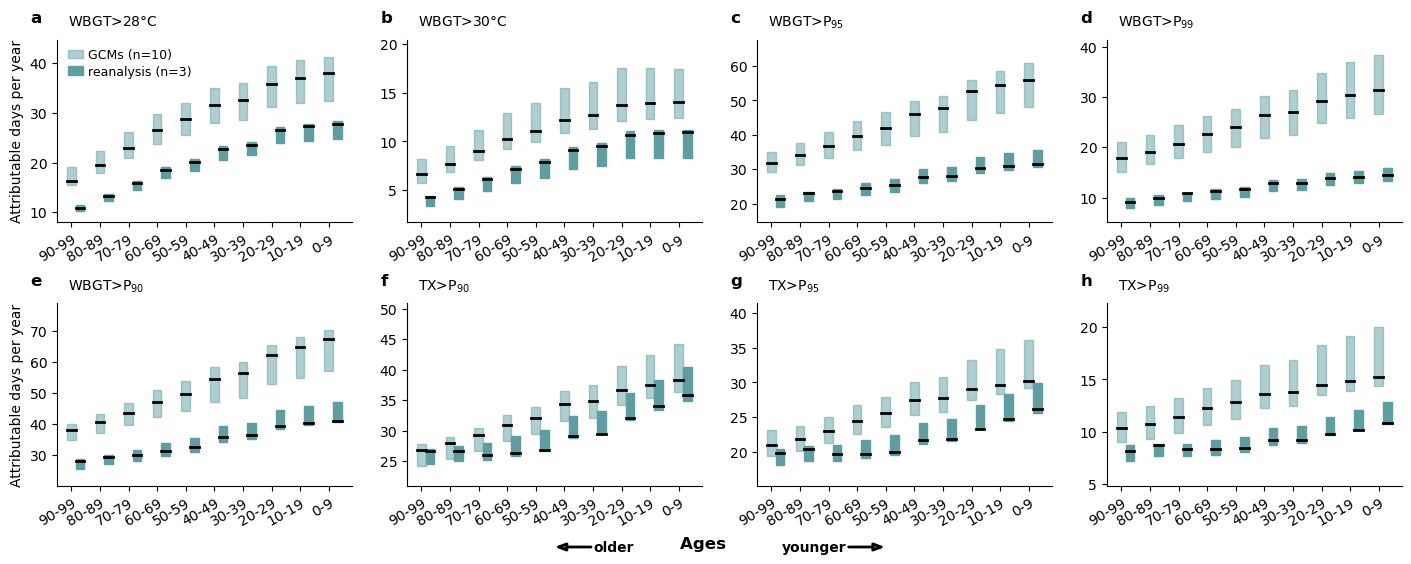

In [49]:
# settings
xpos=-.09
ypos=1.05
shift = 0.15

#ylab=

fig,axes=plt.subplots(2,4,figsize=(14,5.5),layout='constrained',facecolor='none') # 10,5

axes=axes.flatten()


ax=axes[0]
ax.set_title('a',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                             #ylabel='Average attributable days per year',
                              legend=True, 
                              leg_title='WBGT>28$\degree$C',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel='Attributable days per year',
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )




ax=axes[1]
ax.set_title('b',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_30,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                            # ylabel='Attributable days per year',
                              legend=True, 
                              leg_title='WBGT>30$\degree$C',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_30,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel='',
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )



ax=axes[2]
#ax.set_ylim(axes[0].get_ylim())
ax.set_title('c',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_W95,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                            # ylabel='Attributable days per year',
                              legend=True, 
                              leg_title='WBGT>P$_{95}$',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_W95,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel='',
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )




ax=axes[3]
ax.set_title('d',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_W99,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                           #  ylabel='Attributable days per year',
                              legend=True, 
                              leg_title='WBGT>P$_{99}$',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_W99,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel='',
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )


ax=axes[4]
ax.set_title('e',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_W90,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                              legend=True, 
                              leg_title='WBGT>P$_{90}$',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )

plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_W90,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                              ylabel='Attributable days per year',                              
                              legend=False, 
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )



ax=axes[5]
ax.set_title('f',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_TX90,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                           #  ylabel='Attributable days per year',
                              legend=True, 
                              #leg_title='WBGT>P$_{90}$',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_TX90,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel=' ',
                              legend=True, 
                              leg_title='TX>P$_{90}$',
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )



ax=axes[6]
ax.set_title('g',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_TX95,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                           #  ylabel='Attributable days per year',
                              legend=True, 
                              #leg_title='WBGT>P$_{90}$',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_TX95,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel=' ',
                              legend=True, 
                              leg_title='TX>P$_{95}$',
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )





ax=axes[7]
ax.set_title('h',loc='left',fontweight='bold',x=xpos,y=ypos)
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_obs_TX99,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=False,
                              set_xticks=False,
                             rotation=30,
                           #  ylabel='Attributable days per year',
                              legend=True, 
                              #leg_title='WBGT>P$_{90}$',
                              positions = [x - shift for x in range(1,11)],
                              widths=.3
                             )
plot_percapitadays_median_iqr(da_nAHD_percapita_peopledays_10y_models_TX99,
                              feature='per_capita_days',
                              ax=ax,
                             set_xticklabel=True,
                             rotation=30,
                             ylabel=' ',
                              legend=True, 
                              leg_title='TX>P$_{99}$',
                              positions = [x + shift for x in range(1,11)],
                              alpha=.5,
                              widths=.3
                             )





# not really using this loop - clean up 
titles = ['WBGT>28$\degree$C',
          'WBGT>30$\degree$C',
          'WBGT>P$_{95}$',
          'WBGT>P$_{99}$'

]

for ax in [axes[0]]:
    mod_patch = mpatches.Patch(color='cadetblue', alpha=0.5, label='GCMs (n=10)')
    obs_patch = mpatches.Patch(color='cadetblue', label='reanalysis (n=3)')
    leg = ax.legend(handles = [mod_patch, obs_patch ], fontsize=9,frameon=False, loc='upper left',
              handlelength=1.2,handletextpad=0.4,labelspacing = .3,
                    bbox_to_anchor=(0, 1.2),
             title=titles[0]+'\n') 
    leg._legend_box.align = "left"




# Annotations 
fig.supxlabel('Ages ', fontweight='bold'); 




# arrow annotation older/younger 
arr = mpatches.FancyArrowPatch((0.6, 0.015), (0.63, 0.015),  # Coordinates in figure fraction
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )
fig.patches.append(arr)
fig.text(0.554, 0.015, "younger", ha='left', va='center', fontweight='bold')
arr = mpatches.FancyArrowPatch((.42, 0.015), (.39, 0.015),  
                               arrowstyle='-|>,head_width=.15',  
                               mutation_scale=15,  
                               linewidth=2,  
                               transform=fig.transFigure,  
                               )  
fig.patches.append(arr)
fig.text(0.42, 0.015, "older", ha='left', va='center',fontweight='bold')

for ax in axes:
    ax.invert_xaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# Try as dots instead of IQR bar??

#plt.savefig(os.path.join(figdir,'figSI6_percap.png'),dpi=300,bbox_inches='tight',transparent=True)
#plt.savefig(os.path.join(figdir,'figSI6_percap.pdf'),dpi=300,bbox_inches='tight',transparent=True)

## Summary results

In [41]:
da_n_people_ndays_obs.mean(dim='model').to_pandas().applymap(format_large_numbers) # 28 degrees 

features,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50
age_ranges,,,,,
0,865.3M,733.6M,661.6M,557.3M,268.8M
10,846.2M,712.6M,641.3M,539.1M,254.8M
20,783.3M,652.4M,585.7M,491.1M,227.0M
30,744.9M,601.0M,530.4M,437.7M,196.3M
40,626.9M,496.5M,435.2M,357.4M,160.7M
50,522.8M,396.8M,339.7M,275.2M,122.0M
60,366.4M,270.4M,229.2M,184.0M,81.1M
70,197.3M,138.0M,113.8M,88.7M,38.1M
80,69.4M,45.7M,36.8M,27.7M,11.5M


In [42]:
(da_prop_people_ndays_obs * 100).mean(dim='model').to_pandas().round(2)

features,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50
age_ranges,,,,,
0,65.82,55.80,50.33,42.39,20.45
10,65.94,55.53,49.97,42.01,19.86
20,65.84,54.85,49.23,41.28,19.08
30,63.14,50.95,44.96,37.11,16.64
40,62.26,49.31,43.23,35.50,15.96
50,59.73,45.33,38.81,31.44,13.94
60,57.42,42.38,35.92,28.84,12.71
70,54.65,38.24,31.52,24.57,10.55
80,51.31,33.78,27.21,20.46,8.52


In [43]:
da_n_people_ndays_models.mean(dim='model').to_pandas().applymap(format_large_numbers)

features,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50
age_ranges,,,,,
0,976.6M,886.7M,821.4M,686.6M,372.3M
10,960.6M,870.2M,803.1M,663.7M,349.8M
20,893.6M,805.7M,739.6M,604.2M,308.5M
30,874.3M,778.4M,703.9M,555.8M,267.3M
40,739.5M,653.0M,586.4M,458.1M,219.1M
50,638.6M,557.0M,490.6M,367.2M,168.6M
60,450.5M,387.2M,337.7M,249.3M,111.8M
70,245.2M,206.5M,176.9M,125.3M,53.1M
80,85.6M,70.0M,58.7M,40.3M,16.5M


In [44]:
(da_prop_people_ndays_models*100).mean(dim='model').to_pandas().round(2)

features,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50
age_ranges,,,,,
0,74.28,67.45,62.48,52.22,28.32
10,74.85,67.81,62.58,51.72,27.26
20,75.12,67.73,62.17,50.79,25.93
30,74.11,65.98,59.67,47.11,22.66
40,73.45,64.85,58.23,45.49,21.76
50,72.96,63.64,56.06,41.95,19.26
60,70.59,60.68,52.93,39.07,17.51
70,67.91,57.21,48.99,34.70,14.71
80,63.32,51.79,43.43,29.81,12.17


In [45]:
da_n_people_ndays_obs_30.mean(dim='model').to_pandas().applymap(format_large_numbers)

features,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50
age_ranges,,,,,
0,614.6M,463.6M,381.2M,259.8M,43.4M
10,602.1M,452.1M,372.5M,256.6M,41.9M
20,556.1M,415.9M,343.5M,239.0M,38.2M
30,519.5M,375.2M,308.3M,213.4M,33.6M
40,429.7M,305.5M,250.2M,173.2M,27.3M
50,349.8M,234.8M,190.0M,130.5M,20.5M
60,238.9M,157.1M,126.7M,87.2M,13.7M
70,122.6M,75.9M,60.7M,41.6M,6.5M
80,40.4M,23.9M,19.1M,13.0M,2.0M


In [46]:
(da_prop_people_ndays_obs_30*100).mean(dim='model').to_pandas().applymap(format_large_numbers) 

features,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50
age_ranges,,,,,
0,46.7,35.3,29.0,19.8,3.3
10,46.9,35.2,29.0,20.0,3.3
20,46.7,35.0,28.9,20.1,3.2
30,44.0,31.8,26.1,18.1,2.8
40,42.7,30.3,24.8,17.2,2.7
50,40.0,26.8,21.7,14.9,2.3
60,37.4,24.6,19.9,13.7,2.1
70,34.0,21.0,16.8,11.5,1.8
80,29.9,17.7,14.1,9.6,1.5
